<a href="https://colab.research.google.com/github/tedee09/ats-re604-emnist-letter-classification/blob/main/ats_re604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Preparing Dataset**

In [169]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [170]:

df = pd.read_csv("emnist-letters-train.csv", header=None)

In [171]:
df.shape

(88800, 785)

In [172]:
# Shuffle
df = shuffle(df, random_state=2).reset_index(drop=True)

In [173]:
# Separate labels and features
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1,28, 28)

In [174]:
# Change labels from 1-26 to letters A-Z
label_map = {i: chr(64 + i) for i in range(1, 27)}
labels_char = np.array([label_map[label] for label in labels])

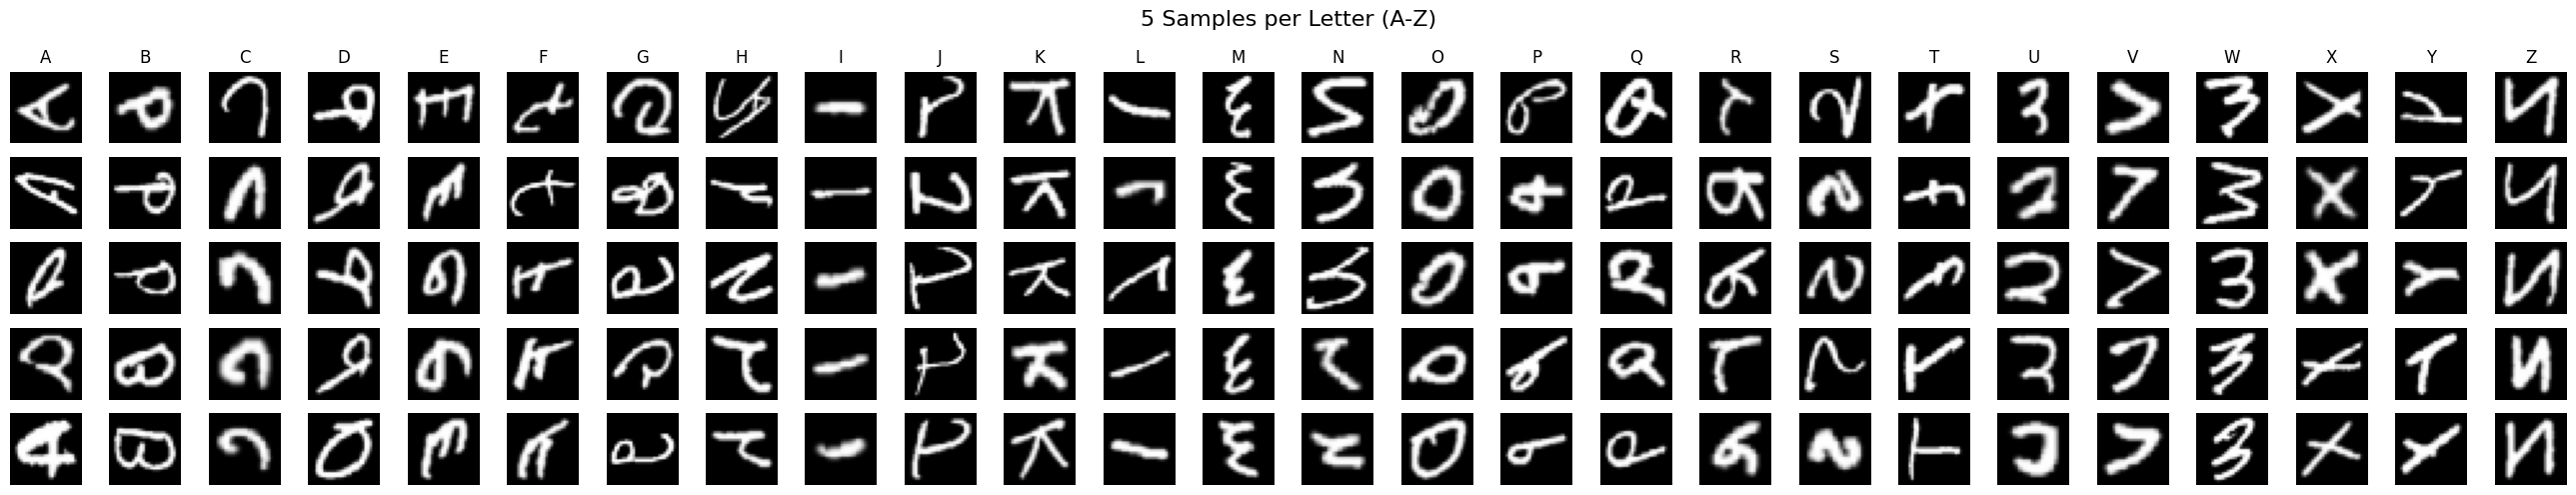

In [175]:
# Visualize Letters A-Z
letters = sorted(list(set(selected_labels_char)))
samples_per_letter = 5

plt.figure(figsize=(26, 5))  # width=26 (1 per letter), height=5 (to fit rows)

for col, letter in enumerate(letters):  # Loop through letters A-Z
    # Get first N samples for this letter
    indices = np.where(selected_labels_char == letter)[0][:samples_per_letter]

    for row, idx in enumerate(indices):
        plt_idx = row * len(letters) + col + 1  # Calculate subplot position
        plt.subplot(samples_per_letter, len(letters), plt_idx)
        plt.imshow(selected_images[idx], cmap="gray")
        plt.title(letter if row == 0 else "")  # Show letter only in first row
        plt.axis("off")

plt.suptitle(f"{samples_per_letter} Samples per Letter (A-Z)", fontsize=16)
plt.tight_layout()
plt.show()


In [176]:
#fetch 100 Data per Letter

selected_indices = []
for label in range(1, 27):
    idx = np.where(labels == label)[0][:100]
    selected_indices.extend(idx)

selected_images = images[selected_indices]
selected_labels = labels[selected_indices]
selected_labels_char = labels_char[selected_indices]

## **2. HOG Feature Extraction**

In [190]:
#HOG Feature Extraction

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

hog_features = []
for img in selected_images:
    feature = hog(img, orientations=12, pixels_per_cell=(4, 4),
                  cells_per_block=(3, 3), block_norm='L2-Hys')
    hog_features.append(feature)

hog_features = np.array(hog_features)


In [191]:
# Normalize
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)

## **3. SVM + Grid Search**

In [179]:
# SVM Training with Grid Search

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(
    hog_scaled, selected_labels, test_size=0.2, random_state=2, stratify=selected_labels)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf','linear']
}


clf = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## **4. Evaluation Model**

In [192]:
# Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8192
Precision: 0.8281
Recall: 0.8192
F1 Score: 0.8184


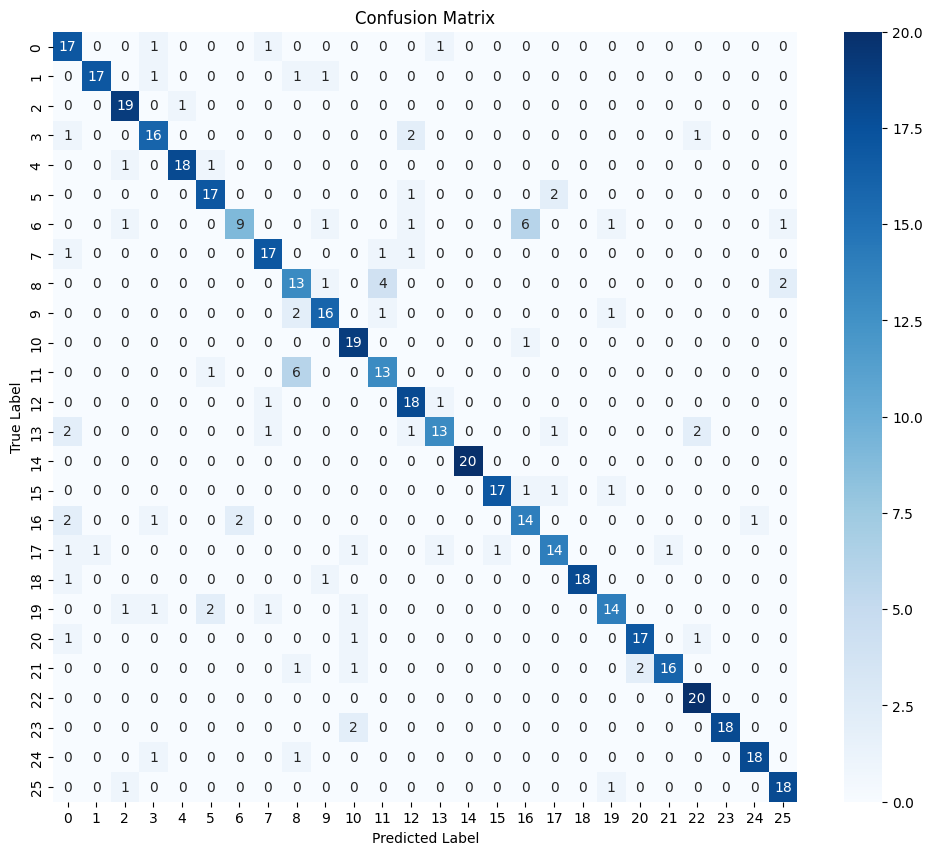

In [193]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **5. Evaluation with Leave-One-Out Cross Validation (LOOCV)**

In [194]:
# Evaluation with Leave-One-Out Cross Validation (LOOCV)
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report

In [195]:
# Initialize LOOCV
loo = LeaveOneOut()

In [196]:
# Create an SVM model with the best parameters from the previous grid
best_svm = svm.SVC(
    C=clf.best_params_['C'],
    gamma=clf.best_params_['gamma'],
    kernel=clf.best_params_['kernel']
)

y_true_loo = []
y_pred_loo = []

In [198]:
# fetch 260 sample for each letter

sample_indices = []
for label in range(1, 27):
    idx = np.where(selected_labels == label)[0][:10]
    sample_indices.extend(idx)

X_loo = hog_scaled[sample_indices]
y_loo = selected_labels[sample_indices]

In [199]:
for train_idx, test_idx in loo.split(X_loo):
    X_tr, X_te = X_loo[train_idx], X_loo[test_idx]
    y_tr, y_te = y_loo[train_idx], y_loo[test_idx]

    best_svm.fit(X_tr, y_tr)
    pred = best_svm.predict(X_te)

    y_true_loo.append(y_te[0])
    y_pred_loo.append(pred[0])

In [200]:
# LOOCV final evaluation
print("LOOCV evaluation :")
print(f"Accuracy : {accuracy_score(y_true_loo, y_pred_loo):.4f}")
print(f"Precision: {precision_score(y_true_loo, y_pred_loo, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true_loo, y_pred_loo, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true_loo, y_pred_loo, average='macro'):.4f}")

LOOCV evaluation :
Accuracy : 0.5385
Precision: 0.5806
Recall   : 0.5385
F1 Score : 0.5479


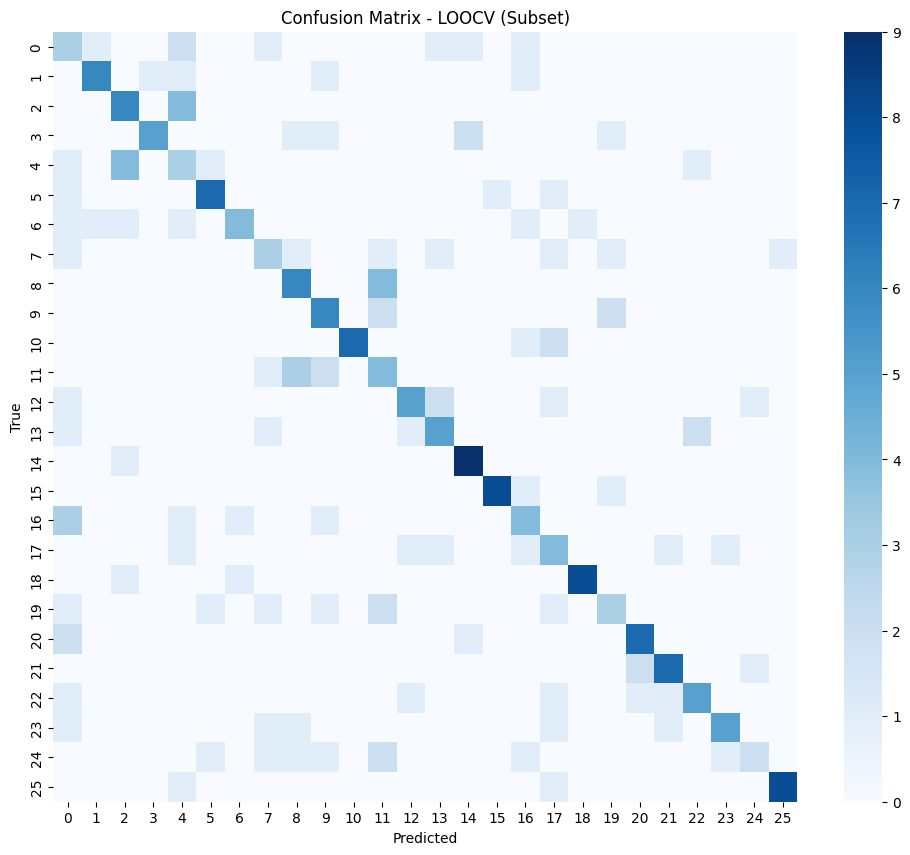

In [201]:
# Confusion matrix
cm_loo = confusion_matrix(y_true_loo, y_pred_loo)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_loo, annot=False, cmap='Blues')
plt.title("Confusion Matrix - LOOCV (Subset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()